In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from   time import time
from   torchvision import datasets, transforms
from   torch import nn, optim

In [4]:
transform   = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset    = datasets.MNIST('train', download = True, train = True , transform = transform)
valset      = datasets.MNIST('val  ', download = True, train = False, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valloader   = torch.utils.data.DataLoader(valset  , batch_size = 64, shuffle = True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [14]:
input_size   = 784
hidden_sizes = [128, 64]
output_size  = 10

sizes = [input_size] + hidden_sizes

layers  = sum([[nn.Linear(start, end), nn.ReLU()] for start, end in zip(sizes, sizes[1:])], [])
layers += [nn.Linear(sizes[-1], output_size), nn.LogSoftmax(dim = 1)]

model = nn.Sequential(*layers)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [15]:
criterion      = nn.NLLLoss()
images, labels = next(iter(trainloader))
images         = images.view(images.shape[0], -1)

logps = model(images)            # log probabilities
loss  = criterion(logps, labels) # calculate the NLL loss

In [16]:
optimizer = optim.Adam(model.parameters(), lr = 1e-2)
time0     = time()
epochs    = 15

for e in range(1, epochs + 1):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {e:3d} - Training loss: {running_loss / len(trainloader)}")

m, s = divmod(time() - time0, 60)
print(f"\nTraining Time = {m:.0f}m {s:.0f}s")

Epoch 0 - Training loss: 0.37222210715002596
Epoch 1 - Training loss: 0.24473624004483985
Epoch 2 - Training loss: 0.22774460676040795
Epoch 3 - Training loss: 0.21461422223625565
Epoch 4 - Training loss: 0.20903508504554788
Epoch 5 - Training loss: 0.20306867306013462
Epoch 6 - Training loss: 0.19671273430281166
Epoch 7 - Training loss: 0.18028783898449133
Epoch 8 - Training loss: 0.1832902121858032
Epoch 9 - Training loss: 0.18198635381336675
Epoch 10 - Training loss: 0.17938042724721515
Epoch 11 - Training loss: 0.16975273306556998
Epoch 12 - Training loss: 0.17249235576554847
Epoch 13 - Training loss: 0.17139825275314768
Epoch 14 - Training loss: 0.17279445266386848

Training Time = 1m 59


In [43]:
images, labels = next(iter(valloader))

img = images.view(-1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)



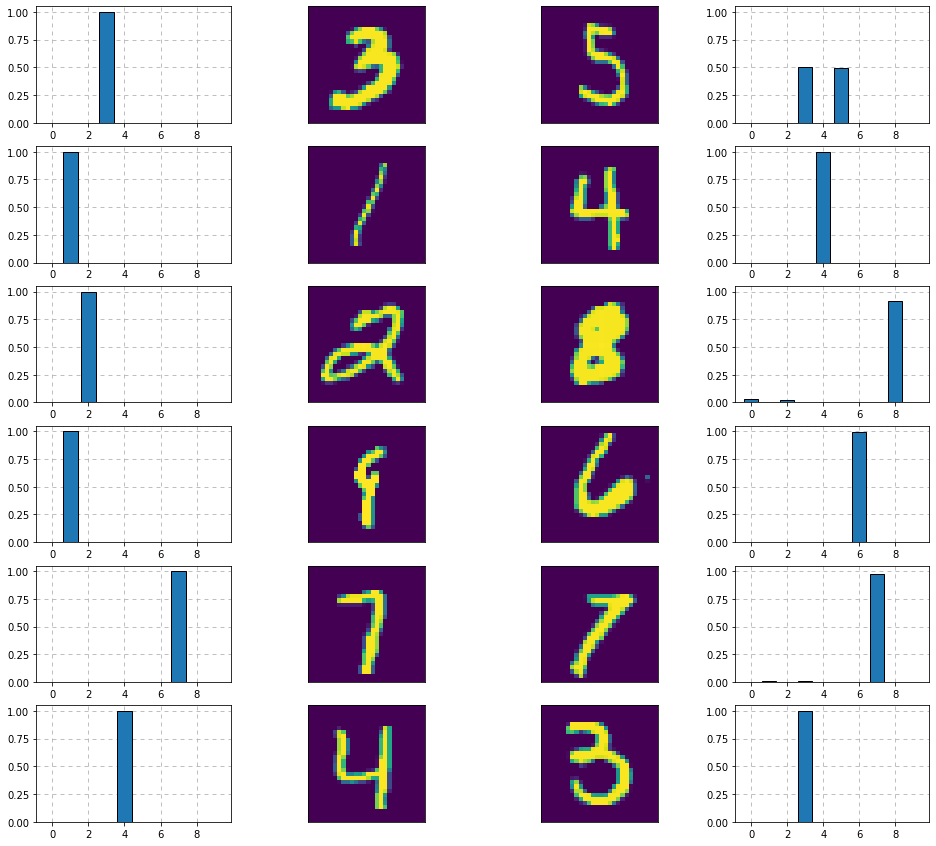

In [61]:
fig, ax = plt.subplots(6, 4, figsize = (16, 15))

for i in range(6):
    ax[i,0].bar(range(10), ps.numpy()[i * 2], ec = 'k', zorder = 3)
    ax[i,1].imshow(images.numpy()[i * 2, 0])
    ax[i,2].imshow(images.numpy()[i * 2 + 1, 0])
    ax[i,3].bar(range(10), ps.numpy()[i * 2 + 1], ec = 'k', zorder = 3)
    
    for j in [1, 2]:
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

    for j in [0, 3]:
        ax[i,j].set_ylim((0, 1.05))
        ax[i,j].grid(ls = (0, (5, 5)))
